In [1]:
from google.cloud import texttospeech as tts
from google.cloud import translate
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import librosa

%matplotlib inline 

In [2]:
TTS_CLIENT = tts.TextToSpeechClient()
TRANS_CLIENT = translate.Client()

In [3]:
VOICES_LIST = TTS_CLIENT.list_voices().ListFields()[0][1]
WAVENET_VOICES = [voice for voice in VOICES_LIST if 'Wavenet' in voice.ListFields()[1][1]]
STANDARD_VOICES = [voice for voice in VOICES_LIST if 'Standard' in voice.ListFields()[1][1]]

In [4]:
SELECTED_VOICES = list()
list_ = [0,1,2,3,4,5,6,7,8,9,13,17,26,27,28]

for i, voice in enumerate(VOICES_LIST):
    if i in list_:
        SELECTED_VOICES.append(voice)

In [5]:
def get_VoiceSelectionParams(voice):
    
    voice_data = voice.ListFields()
    
    return tts.types.VoiceSelectionParams(
        language_code = voice_data[1][1], # Using the name to define the language
        ssml_gender = voice_data[2][1],
    )

In [6]:
def get_lang(voice):
    
    return voice.ListFields()[0][1][0]

In [7]:
def translate(word, target, client=TRANS_CLIENT):

    translation = client.translate(
            str(word),
            target_language=target)
    return translation['translatedText']

In [8]:
def get_synthetic_audio(voice, text, client=TTS_CLIENT):

    input_text = tts.types.SynthesisInput(text=text)

    audio_config = tts.types.AudioConfig(
        audio_encoding=tts.enums.AudioEncoding.LINEAR16)
    voice_selection_params = get_VoiceSelectionParams(voice)

    response = client.synthesize_speech(input_text, voice_selection_params, audio_config)
    return wavfile.read(BytesIO(response.audio_content))


In [9]:
def generate_data(word, voices_list):
    
    audios = list()
    labels = list()
    rates = list()

    
    for i, voice in enumerate(voices_list):
        
        translated_word = word
        lang = get_lang(voice)
        
        # Array slice is to get the first par the the locale (eg. '[fr]_ca')
        if lang[:2] is not 'en':
            translated_word = translate(word, lang[:2])
            
        rate, audio =  get_synthetic_audio(voice, translated_word)   
        
        audios.append(audio)
        rates.append(rate)
        labels.append("{} - {}".format(i,lang))
        
    return (audios, labels, rates)

In [10]:
dog_audios, dog_labels, dog_rates = generate_data('dog', SELECTED_VOICES)

In [11]:
trimmed_audios = list()

for audio in dog_audios:
    trimmed_audios.append(audio[audio>0.5])

In [12]:
padded_audios = list()

for audio in trimmed_audios:
    padded_audios.append(librosa.util.fix_length(audio, 10000))

In [14]:
shape = (len(SELECTED_VOICES),10000)
X = np.concatenate(padded_audios).reshape(shape)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/home/leko/python/env/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_scaled)

<Figure size 1440x1440 with 0 Axes>

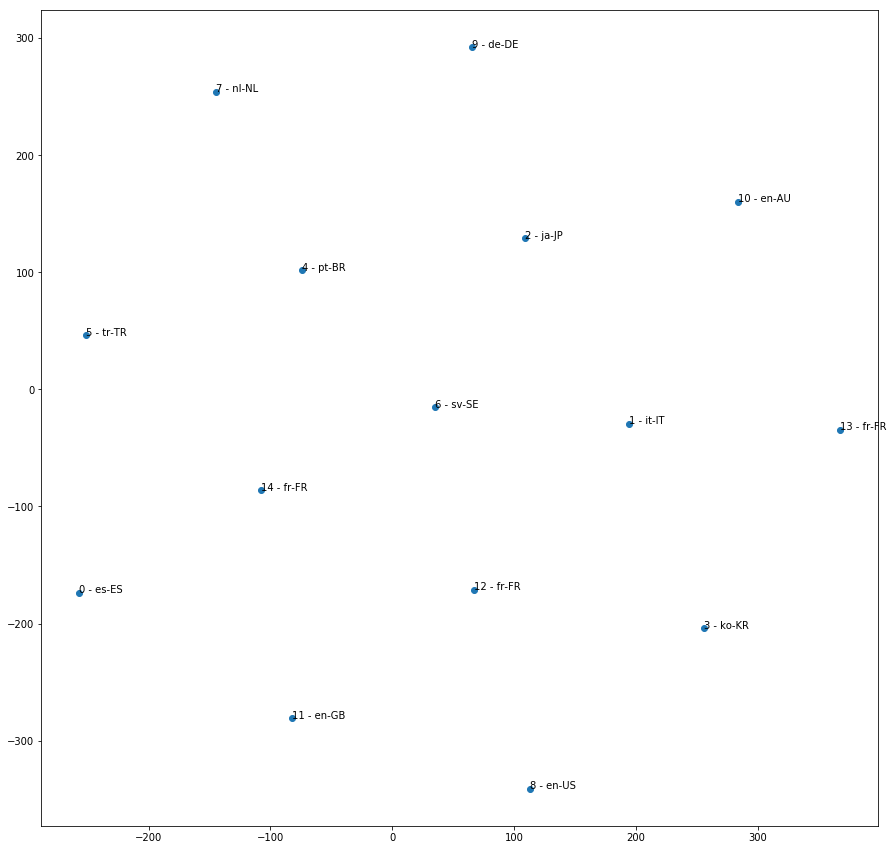

<Figure size 1440x1440 with 0 Axes>

In [19]:
plt.rcParams["figure.figsize"] = (15,15)fig, ax = plt.subplots()
plt.figure(figsize=(20,20))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1])

for i, label in enumerate(dog_labels):
    ax.annotate(label, (X_reduced[i, 0], X_reduced[i, 1]))